In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight 
import pickle
import gzip 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

In [2]:
def TS_data(ts, lag, n_ahead, target_index=-1):
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]-1
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag),:-1])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

def TS_split(Final_data, lag, n_ahead):
    import random
    with gzip.open('cleaned_data.zip','rb') as data:
        data = pd.read_csv(data,index_col=[0,1])
    idlist = data.groupby('uuid').count().index

    random.seed(505)
    randid = random.sample(list(range(0,len(idlist))), len(idlist))

    train_data = pd.DataFrame()
    validation_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for i in randid[0:38]:
        train_data = pd.concat([train_data, Final_data.loc[idlist[i]]], axis = 0)
        
    for i in randid[38:45]:
        validation_data = pd.concat([validation_data, Final_data.loc[idlist[i]]], axis = 0)

    for i in randid[45:]:
        test_data = pd.concat([test_data, Final_data.loc[idlist[i]]], axis = 0)
    
    
    x_train, y_train = TS_data(train_data.values, lag, n_ahead)
    
    x_val, y_val = TS_data(validation_data.values, lag, n_ahead)
    
    x_test, y_test = TS_data(test_data.values, lag, n_ahead)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [51]:
def splitdata(Final_data,test_size,time_step,n_pred):

    # Split training and validation dataset

    x_train, x_test, y_train, y_test = train_test_split(Final_data.iloc[:,:-1], Final_data.iloc[:,-1], test_size=test_size, shuffle=True)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=test_size, shuffle=True)
    
    
    def augmentation(data_X,data_Y,time_step,n_pred):
        n_features = data_X.shape[1]
        # Creating placeholder lists
        X, Y = [], []

        if len(data_X) - time_step <= 0:
            X.append(data_X)
        else:
            for i in range(len(data_X) - time_step - n_pred):
                Y.append(data_Y[(i + time_step):(i + time_step + n_pred)])
                X.append(data_X[i:(i + time_step)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an RNN input shape 
        X = np.reshape(X, (X.shape[0], time_step, n_features))
        return X,Y
    
    x_train, y_train = augmentation(x_train, y_train,time_step,n_pred)
    x_test, y_test = augmentation(x_test, y_test,time_step,n_pred)
    x_val, y_val = augmentation(x_val, y_val,time_step,n_pred)

    return x_train, y_train, x_val, y_val, x_test, y_test

In [4]:
with gzip.open('cleaned_data.zip','rb') as file:
    feature_data = pd.read_csv(file,index_col=[0,1])

with gzip.open('new_label_data.zip','rb') as file:
    new_label_data = pd.read_csv(file,index_col=[0,1])

data = pd.concat([feature_data,new_label_data],join='inner',ignore_index=False,axis=1)



In [68]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = TS_split(data,10,3)
X_train.shape

(221007, 10, 50)

In [69]:
Y_train.shape

(221007, 3)

In [79]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

input_dim = X_train.shape[2]
time_step = X_train.shape[1]
units = 128
batch_size = 32
output_size = Y_train.shape[1]  # labels are from 0 to 6
def build_model():
# Build the RNN model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(time_step, input_dim)))
    model.add(Dropout(0.2))
    model.add(RepeatVector(output_size))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(7, activation='softmax')))
    return model

In [80]:
model = build_model()

model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 200)               200800    
                                                                 
 dropout_60 (Dropout)        (None, 200)               0         
                                                                 
 repeat_vector_17 (RepeatVec  (None, 3, 200)           0         
 tor)                                                            
                                                                 
 lstm_34 (LSTM)              (None, 3, 200)            320800    
                                                                 
 dropout_61 (Dropout)        (None, 3, 200)            0         
                                                                 
 time_distributed_2 (TimeDis  (None, 3, 100)           20100     
 tributed)                                           

In [81]:
model = build_model()

#model.summary()
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer="Adamax",
    metrics=["accuracy"]
)
GRU_model = model.fit(X_train, Y_train, validation_data=(X_val,Y_val), batch_size=batch_size, epochs=10, verbose=1)

Epoch 1/10
6907/6907 [==============================] - 196s 19ms/step - loss: 9.1472 - accuracy: 0.3451 - val_loss: 2.5089 - val_accuracy: 0.3154
Epoch 2/10
6907/6907 [==============================] - 134s 19ms/step - loss: 1.9033 - accuracy: 0.3283 - val_loss: 1.7276 - val_accuracy: 0.3470
Epoch 3/10
6907/6907 [==============================] - 134s 19ms/step - loss: 1.6976 - accuracy: 0.3495 - val_loss: 1.7047 - val_accuracy: 0.3527
Epoch 4/10
6907/6907 [==============================] - 107s 15ms/step - loss: 1.6679 - accuracy: 0.3669 - val_loss: 1.7079 - val_accuracy: 0.3553
Epoch 5/10
6907/6907 [==============================] - 106s 15ms/step - loss: 1.6548 - accuracy: 0.3717 - val_loss: 1.6910 - val_accuracy: 0.3673
Epoch 6/10
6907/6907 [==============================] - 116s 17ms/step - loss: 1.6399 - accuracy: 0.3744 - val_loss: 1.7082 - val_accuracy: 0.3522
Epoch 7/10
6907/6907 [==============================] - 142s 21ms/step - loss: 1.6265 - accuracy: 0.3834 - val_loss: 1

In [82]:
model.save('./GRU_model')
with open('./GRU_model/log.txt', 'wb') as file_txt:
    pickle.dump(GRU_model.history, file_txt)

INFO:tensorflow:Assets written to: ./GRU_model\assets


INFO:tensorflow:Assets written to: ./GRU_model\assets


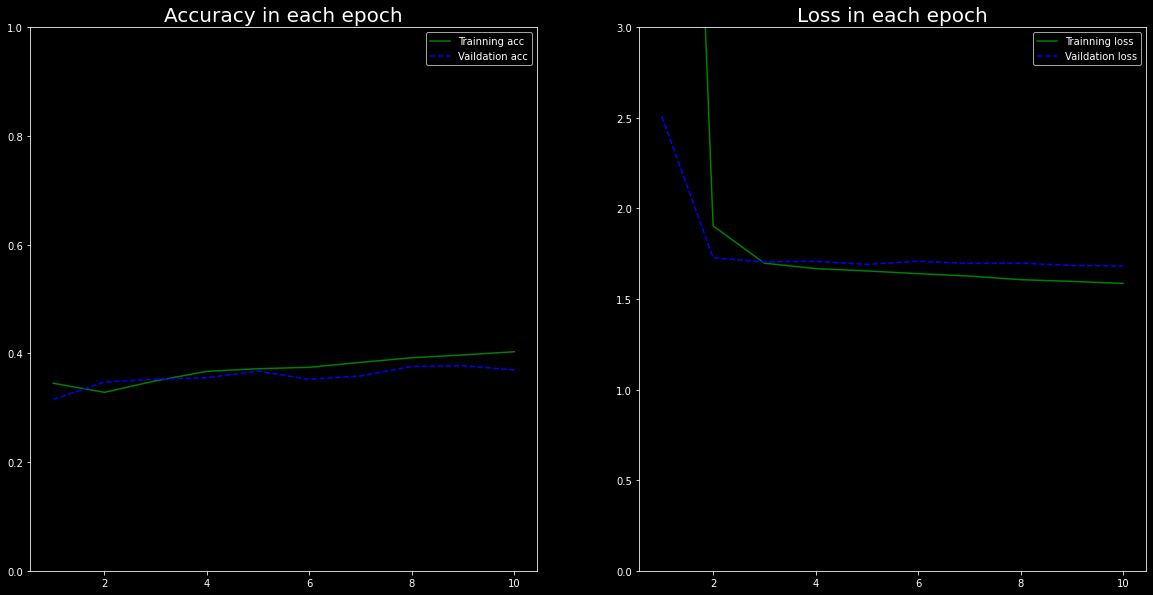

In [83]:
with open('./GRU_model/log.txt','rb') as file_txt:
    history=pickle.load(file_txt)

acc = history['accuracy']     #获取训练集准确性数据
val_acc = history['val_accuracy']    #获取验证集准确性数据
loss = history['loss']          #获取训练集错误值数据
val_loss = history['val_loss']  #获取验证集错误值数据

epochs = range(1,len(acc)+1)
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.plot(epochs,acc,'g',label='Trainning acc')     #以epochs为横坐标，以训练集准确性为纵坐标
ax1.plot(epochs,val_acc,'b--',label='Vaildation acc') #以epochs为横坐标，以验证集准确性为纵坐标
ax1.legend()   #绘制图例，即标明图中的线段代表何种含义
ax1.set_title('Accuracy in each epoch',fontsize=20)
plt.ylim(0,1)
ax2 = fig.add_subplot(122)
ax2.plot(epochs,loss,'g',label='Trainning loss')
ax2.plot(epochs,val_loss,'b--',label='Vaildation loss')
ax2.legend()  ##绘制图例，即标明图中的线段代表何种含义
ax2.set_title('Loss in each epoch',fontsize=20)
plt.ylim(0,3)
plt.show()

1069/1069 [==============================] - 8s 7ms/step


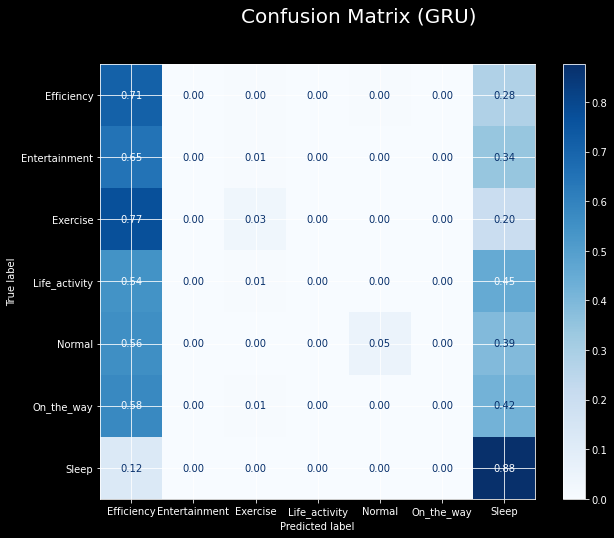

In [99]:
from sklearn import metrics

load_model = keras.models.load_model('./GRU_model')

predictions = load_model.predict(X_test)
y_test_pred = np.argmax(predictions[:,2,:], axis=1)

new_label_dict = {0:'Sleep', 1:'Efficiency', 2:'Exercise', 3:'Life_activity', 4:'Entertainment', 5:'On_the_way', 6:'Normal'}
y_test_pred = [new_label_dict.get(i) for i in y_test_pred]
y_test_true = [new_label_dict.get(int(z)) for z in [j for j in [i for i in Y_test[:,2]]]]


confusion = metrics.ConfusionMatrixDisplay.from_predictions(y_test_true,y_test_pred,cmap='Blues',normalize='true',values_format='.2f')
confusion.figure_.suptitle("Confusion Matrix (GRU)",fontsize=20)
confusion.figure_.set_size_inches(10,8)
plt.grid(visible=None)
plt.show()

In [123]:
np.argmax(predictions[0:100,0,:],axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)